<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/6-deep-learning-for-text-and-sequences/4_understanding_lstm_and_gru_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the LSTM and GRU layers

**A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept in between inputs.**

**With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point.**

For instance, this is what you did in the IMDB example: an entire movie review was transformed into a single large vector(flatten) and processed in one go. Such networks are called **feedforward networks**.

In contrast, as you’re reading the present sentence, you’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence.

**Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in**.

A **recurrent neural network (RNN)** adopts the same principle, albeit in an extremely simplified version: **it processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop.**

The state of the RNN is reset between processing two different,
independent sequences (such as two different IMDB reviews), so you still consider one sequence a single data point: **a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.**

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/recurrent-neural-network.png?raw=1' width='800'/>

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Embedding

from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd

import string
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Understanding the LSTM and GRU layers

SimpleRNN isn’t the only recurrent layer available in Keras. **There are two others: LSTM and GRU.** In practice, you’ll always use one of these, because SimpleRNN is generally too simplistic to be of real use. **SimpleRNN has a major issue:** although it should theoretically be able to retain at time t information about inputs seen many timesteps before, in practice, such long-term dependencies are impossible to learn. **This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep**: as you keep adding layers to a network, the network eventually becomes untrainable. **The LSTM and GRU layers are designed to solve this problem.**

Let’s consider the LSTM layer. The underlying Long Short-Term Memory (LSTM)
algorithm was developed by Hochreiter and Schmidhuber in 1997; it was the culmination of their research on the vanishing gradient problem.

This layer is a variant of the SimpleRNN layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. **This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.**

To understand this in detail, let’s start from the SimpleRNN cell. Because you’ll have a lot of weight matrices, index the W and U matrices in the cell with the letter o (Wo and Uo) for output.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/simple-RNN.png?raw=1' width='800'/>

Let’s add to this picture an additional data flow that carries information across timesteps. Call its values at different timesteps Ct, where C stands for carry. This information will have the following impact on the cell: it will be combined with the input connection and the recurrent connection (via a dense transformation: a dot product with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep (via an activation function an a multiplication operation). Conceptually, the carry dataflow is a way to modulate the next output and the next state.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/lstm-rnn.png?raw=1' width='800'/>

Now the subtlety: **the way the next value of the carry dataflow is computed. It involves three distinct transformations. All three have the form of a SimpleRNN cell**:

```python
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```

But all three transformations have their own weight matrices, which you’ll index with the letters i, f, and k. Here’s what you have so far (it may seem a bit arbitrary, but bear with me).

```python
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```

You obtain the new carry state (the next c_t) by combining i_t, f_t, and k_t.

```python
c_t+1 = i_t * k_t + c_t * f_t
```

And that’s it. Not so complicated—merely a tad complex.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/LSTM-Anatomy.png?raw=1' width='800'/>

If you want to get philosophical, you can interpret what each of these operations is meant to do. For instance, you can say that multiplying c_t and f_t is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, i_t and k_t provide information about the present, updating the carry track with new information.

But at the end of the day, these interpretations don’t mean much, because what these operations actually do is determined by the contents of the weights parameterizing them; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. 

The specification of an RNN cell (as just described) determines your hypothesis
space—the space in which you’ll search for a good model configuration during
training—but it doesn’t determine what the cell does; that is up to the cell weights. The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints on your search, not as a design in an engineering sense.

To a researcher, it seems that the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers. And in the future, that’s how we’ll build networks. 

**In summary: you don’t need to understand anything about the specific architecture of an LSTM cell; as a human, it shouldn’t be your job to
understand it. Just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.**


## A concrete LSTM example in Keras

Now let’s switch to more practical concerns: you’ll set up a model using an LSTM layer and train it on the IMDB data. The network is similar to the
one with SimpleRNN that was just presented. You only specify the output dimensionality of the LSTM layer; leave every other argument (there are many) at the Keras defaults. Keras has good defaults, and things will almost always “just work” without you having to spend time tuning parameters by hand.

Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [4]:
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [5]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [6]:
# number of words to consider as features
voc_size = (input_train.max()+1).astype('int64')
print(voc_size)

model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

10000
Epoch 1/10
157/157 [==============================] - 6s 39ms/step - loss: 0.5030 - accuracy: 0.7570 - val_loss: 0.3687 - val_accuracy: 0.8616
Epoch 2/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2938 - accuracy: 0.8836 - val_loss: 0.3030 - val_accuracy: 0.8748
Epoch 3/10
157/157 [==============================] - 6s 36ms/step - loss: 0.2358 - accuracy: 0.9116 - val_loss: 0.3113 - val_accuracy: 0.8670
Epoch 4/10
157/157 [==============================] - 6s 35ms/step - loss: 0.2006 - accuracy: 0.9261 - val_loss: 0.2836 - val_accuracy: 0.8890
Epoch 5/10
157/157 [==============================] - 6s 36ms/step - loss: 0.1748 - accuracy: 0.9382 - val_loss: 0.2908 - val_accuracy: 0.8876
Epoch 6/10
157/157 [==============================] - 6s 36ms/step - loss: 0.1618 - accuracy: 0.9422 - val_loss: 0.3555 - val_accuracy: 0.8680
Epoch 7/10
157/157 [==============================] - 6s 36ms/step - loss: 0.1427 - accuracy: 0.9481 - val_loss: 0.3546 - val_accuracy: 

Let's display the training and validation loss and accuracy:

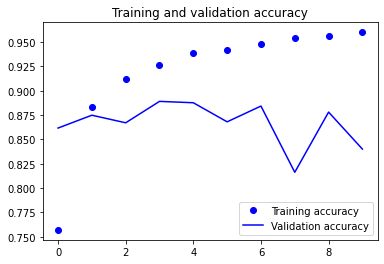

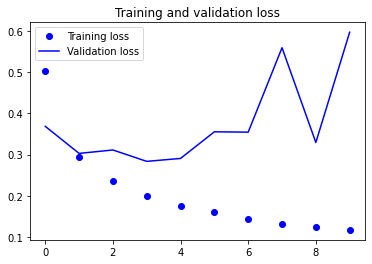

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This time, you achieve up to 89% validation accuracy. Not bad: certainly much better than the SimpleRNN network—that’s largely because LSTM suffers much less from the vanishing-gradient problem—and slightly better than the fully connected approach.

But this result isn’t groundbreaking for such a computationally intensive
approach. Why isn’t LSTM performing better? One reason is that you made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality. Another may be lack of regularization. But honestly, the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the first fully connected approach looked at. 

**But there are far more difficult natural language processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.**